In [1]:
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 52.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: tensorfl

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


modules loaded


In [3]:
! python --version

Python 3.10.12


In [4]:
# Generate data paths with labels
data_dir = '/kaggle/input/multiclass-weather-dataset/Multi-class Weather Dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
df

,filepaths,labels
0,/kaggle/input/multiclass-weather-dataset/Multi...,Cloudy
1,/kaggle/input/multiclass-weather-dataset/Multi...,Cloudy
2,/kaggle/input/multiclass-weather-dataset/Multi...,Cloudy
3,/kaggle/input/multiclass-weather-dataset/Multi...,Cloudy
4,/kaggle/input/multiclass-weather-dataset/Multi...,Cloudy
...,...,...
1120,/kaggle/input/multiclass-weather-dataset/Multi...,Shine
1121,/kaggle/input/multiclass-weather-dataset/Multi...,Shine
1122,/kaggle/input/multiclass-weather-dataset/Multi...,Shine
1123,/kaggle/input/multiclass-weather-dataset/Multi...,Shine


In [6]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [7]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 900 validated image filenames belonging to 4 classes.
Found 135 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.


In [8]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", 
                                                               input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', 
              metrics= ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                        tf.keras.metrics.AUC()])

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non

In [9]:
epochs = 25   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/25
57/57 [==============================] - 41s 331ms/step - loss: 8.0230 - accuracy: 0.8011 - precision: 0.8333 - recall: 0.7833 - auc: 0.9563 - val_loss: 7.7937 - val_accuracy: 0.8296 - val_precision: 0.8333 - val_recall: 0.8148 - val_auc: 0.9630
Epoch 2/25
57/57 [==============================] - 13s 230ms/step - loss: 6.7788 - accuracy: 0.9422 - precision: 0.9481 - recall: 0.9333 - auc: 0.9924 - val_loss: 6.5761 - val_accuracy: 0.9333 - val_precision: 0.9403 - val_recall: 0.9333 - val_auc: 0.9947
Epoch 3/25
57/57 [==============================] - 14s 235ms/step - loss: 5.9145 - accuracy: 0.9689 - precision: 0.9752 - recall: 0.9611 - auc: 0.9987 - val_loss: 5.6605 - val_accuracy: 0.9630 - val_precision: 0.9627 - val_recall: 0.9556 - val_auc: 0.9983
Epoch 4/25
57/57 [==============================] - 13s 229ms/step - loss: 5.2561 - accuracy: 0.9633 - precision: 0.9684 - recall: 0.9533 - auc: 0.9962 - val_loss: 4.9926 - val_accuracy: 0.9630 - val_precision: 0.9701 - val_recal

In [10]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 0s 177ms/step - loss: 0.8756 - accuracy: 0.9375 - precision: 0.9355 - recall: 0.9062 - auc: 0.9974
Train Loss:  0.7649936676025391
Train Accuracy:  1.0
--------------------
Validation Loss:  0.9221909046173096
Validation Accuracy:  0.96875
--------------------
Test Loss:  0.8755661845207214
Test Accuracy:  0.9375


In [11]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

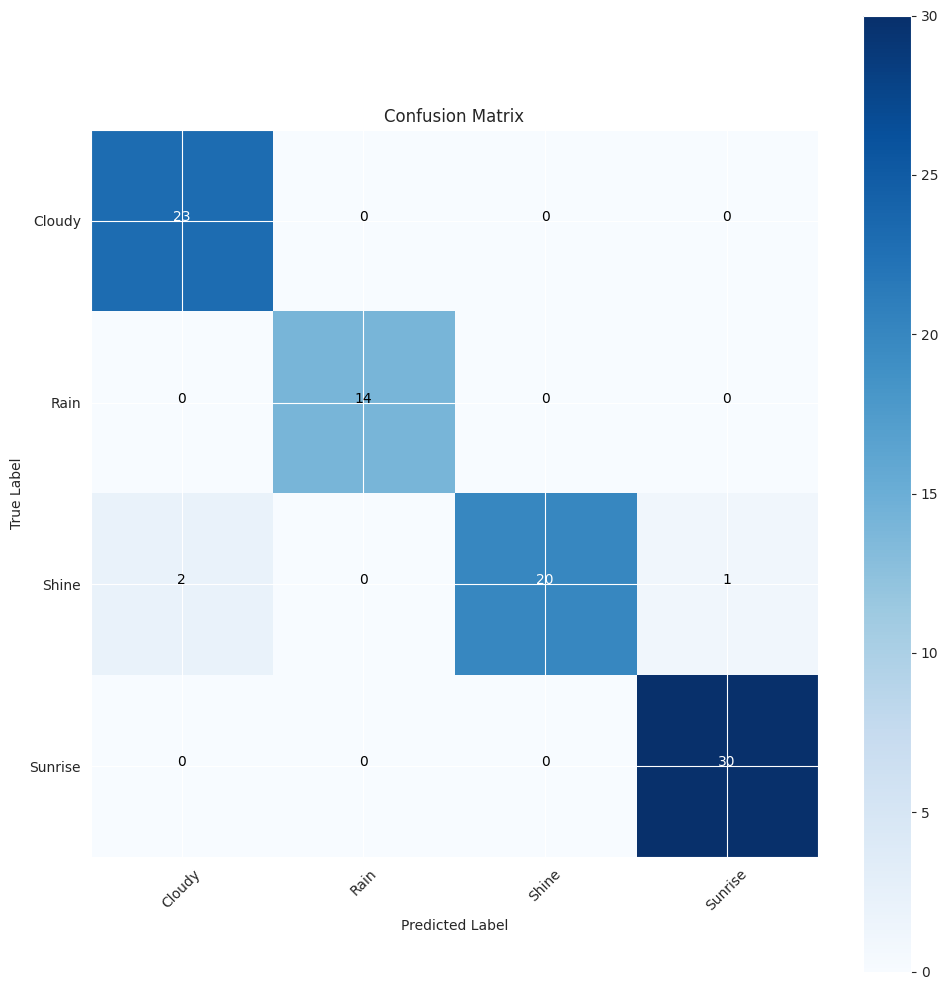

In [12]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

    

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [13]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      Cloudy       0.92      1.00      0.96        23
        Rain       1.00      1.00      1.00        14
       Shine       1.00      0.87      0.93        23
     Sunrise       0.97      1.00      0.98        30

    accuracy                           0.97        90
   macro avg       0.97      0.97      0.97        90
weighted avg       0.97      0.97      0.97        90



In [14]:
#Save the model
model.save('ًWeather Model.h5')